This code implements the referencing with a neural network when using a reference spectrum in transient absorption spectroscopy. The script performs the following operations

      (1) Setting up a neural network model

      (2) Training (fitting) the model with data of the reference and signal spectrum without the pump. The dataset is slit in training and test set to monitor the performance.
   
      (3) Using the fitted model to perform de-noising on pump probe data


Inputs (required):

      signal_pump_raw & signal_Npump_raw = signal spectra for pump on and off 
            size (Npixel x Ndelays x Nacquisition)
   
      reference_pump_raw & reference_Npump_raw = reference spectra for pump on and off 
            size (Npixel x Ndelays x Nacquisition)

      x_data = Set of refecense spectra without the pump, e.g. reference_Npump_raw for every time delay
            size (Nacquisition x Npixel), as numpy array

      y_data = Set of signal spectra without the pump, e.g. signal_Npump_raw for every time delay
            size (Nacquisition x Npixel), as numpy array

      For optimal performance of the neural network, all values need to be scaled in the range 0 to 1 by devinding the maximal intensity! 
Outputs:

      dOD_list = Delta OD for every delay and pixel
            size(Ndelays x Npixel)

      Error_list = error of the mean
            size(Ndelays x Npixel)



Citation for this code or some of its parts: T. Heinrich et al. "Suppression of high-harmonic source noise with machine learning" (to be published)

In [1]:
#import, using Keras with Tensorflow backend
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import numpy as np
import scipy.io
import h5py

#provide inputs, for example:
hf = h5py.File('data.h5', 'r')
signal_pump_raw=np.array(hf.get('P_Sig_raw'))
signal_Npump_raw=np.array(hf.get('N_Sig_raw'))
reference_pump_raw=np.array(hf.get('P_Ref_raw'))
reference_Npump_raw=np.array(hf.get('N_Ref_raw'))
x_data=np.array(hf.get('x_data'))
y_data=np.array(hf.get('y_data'))
hf.close()

# (1) Define neural network:

N_in  = np.shape(x_data)[1]  # Number of in neurons (reference)
N_out = np.shape(y_data)[1]  # Number of out neurons (signal)
model_simple = Sequential()  
# 3 hidden layers with relu activation function, output layer with linear activation
model_simple.add(Dense(200, activation='relu', input_shape=(N_in,)))
model_simple.add(Dense(100, activation='relu'))
model_simple.add(Dense(20, activation='relu'))
model_simple.add(Dense(N_out, activation='linear'))  
model_simple.summary()
#gradient decent with adam, mean squares loss function
model_simple.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model_simple.save_weights('model_init.h5') # initiate 'empty' weigts (fitting parameters) 

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               2000      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_4 (Dense)              (None, 15)                315       
Total params: 24,435
Trainable params: 24,435
Non-trainable params: 0
_________________________________________________________________


In [2]:
#(2) train the neural network 

model_simple.load_weights('model_init.h5') # load 'empty' model
random_numer_param=685 # Random value
split_ratio=0.2 # Training test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=split_ratio, random_state=random_numer_param)
batch_size = 50 
# EarlyStopping: the model should stop training when it won't improve anymore
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=50)
epochs = 10000 # max itterations
# train the model
history_simple = model_simple.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[early_stopping_monitor],validation_data=(x_test, y_test))  
#save model weights
FileName='Trained-Weights'
model_simple.save_weights(FileName +'.h5' )
# evaluate model performance
score = model_simple.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])

Train on 58240 samples, validate on 14560 samples
Epoch 1/10000
58240/58240 [==============================] - 3s 52us/step - loss: 0.0033 - accuracy: 0.9299 - val_loss: 3.7382e-05 - val_accuracy: 1.0000
Epoch 2/10000
15700/58240 [=======>......................] - ETA: 2s - loss: 3.7010e-05 - accuracy: 1.0000

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "c:\Users\Tobias Heinrich\Anaconda3\envs\test\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\TOBIAS~1\AppData\Local\Temp/ipykernel_46880/3713521929.py", line 12, in <module>
    history_simple = model_simple.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[early_stopping_monitor],validation_data=(x_test, y_test))
  File "c:\Users\Tobias Heinrich\Anaconda3\envs\test\lib\site-packages\keras\engine\training.py", line 1239, in fit
    validation_freq=validation_freq)
  File "c:\Users\Tobias Heinrich\Anaconda3\envs\test\lib\site-packages\keras\engine\training_arrays.py", line 196, in fit_loop
    outs = fit_function(ins_batch)
  File "c:\Users\Tobias Heinrich\Anaconda3\envs\test\lib\site-packages\tensorflow_core\python\keras\backend.py", line 3727, in __call__
    outputs = self._graph_fn(*converted_inputs)
  File "c:\

In [2]:
# (3) evaluate pump probe data: calculate the transient transmission

# load model weights
FileName='Trained-Weights'
model_simple.load_weights(FileName +'.h5' )

#Outputs
dOD_list=np.zeros((np.shape(signal_pump_raw)[1],np.shape(signal_pump_raw)[0])) # DeltaOD, size(Ndelays x Npixel)
Error_list=np.zeros((np.shape(signal_pump_raw)[1],np.shape(signal_pump_raw)[0])) #Std, size(Ndelays x Npixel)

for jj in range(np.shape(signal_pump_raw)[1]): # iterate delays
    signal_pump=np.transpose(signal_pump_raw[:,jj,:])
    signal_Npump=np.transpose(signal_Npump_raw[:,jj,:])
    reference_pump=np.transpose(reference_pump_raw[:,jj,:])
    reference_Npump=np.transpose(reference_Npump_raw[:,jj,:])
    # evaluate the model
    signal_Npump_predicted = model_simple.predict(reference_Npump)
    signal_pump_predicted = model_simple.predict(reference_pump)
    signal_pump_referenced=signal_pump/signal_pump_predicted # reference pumped spectrum
    signal_Npump_referenced=signal_Npump/signal_Npump_predicted # reference un pumped spectrum
    #compute delta OD & standart deviation
    for ii in range(np.shape(signal_pump_raw)[0]): # iterate pixel           
        dOD=-np.log10(2*(signal_pump_referenced[:,ii]-signal_Npump_referenced[:,ii])/(signal_pump_referenced[:,ii]+signal_Npump_referenced[:,ii])+1) # delta OD
        dOD_list[jj,ii]=np.mean(dOD)     
        Error_list[jj,ii]=np.std(dOD)/np.sqrt(np.shape(dOD)[0]) # error of the mean   

c:\Users\Tobias Heinrich\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log10


In [3]:
from matplotlib.pyplot import figure

import plotly.express as px
import plotly.graph_objects as go
T_zero=262.613
timing=(T_zero-delays)*6.671

fig = go.Figure()
harmonics2=np.int16(np.linspace(0,14,15))
#fig.add_trace(go.Scatter(x=timing,y=Intensity_list[:,14],name='HH '+str(2),error_y=dict(type='data',array=Error_list[:,14],visible=True)))
for jj in harmonics2:

    order=32-jj
    Intensity=dOD_list[:,np.int16(jj)]
    Error=Error_list[:,np.int16(jj)]
    A=timing.argsort()
    timing_sort=timing[A[::-1]]
    Error_sort=Error[A[::-1]]
    Intensity_sort=Intensity[A[::-1]]
    fig.add_trace(go.Scatter(x=timing_sort,y=Intensity_sort,name='HH '+str(order),error_y=dict(type='data',array=Error_sort,visible=True)))
fig.update_layout(width=1300, height=700,title='transient absorption TiSe\u2082',xaxis_title='Delay [ps]', yaxis_title=u"\u0394"+"T/T")
fig.show()

In [8]:
T_zero=262.613
timing=(T_zero-delays)*6.671

fig = go.Figure()
harmonics2=np.int16(np.linspace(0,14,15))
#fig.add_trace(go.Scatter(x=timing,y=Intensity_list[:,14],name='HH '+str(2),error_y=dict(type='data',array=Error_list[:,14],visible=True)))
for jj in harmonics2:

    order=32-jj
    Intensity=Intensity_list[:,np.int16(jj)]
    Error=Error_list[:,np.int16(jj)]
    A=timing.argsort()
    timing_sort=timing[A[::-1]]
    Error_sort=Error[A[::-1]]
    Intensity_sort=Intensity[A[::-1]]
    fig.add_trace(go.Scatter(x=timing_sort,y=Intensity_sort,name='HH '+str(order),error_y=dict(type='data',array=Error_sort,visible=True)))
fig.update_layout(width=1300, height=700,title='transient absorption TiSe\u2082',xaxis_title='Delay [ps]', yaxis_title=u"\u0394"+"T/T")
fig.show()



5.381379634296627e-05
0.00021769046774699506
Error improved by x 4.045253866863609


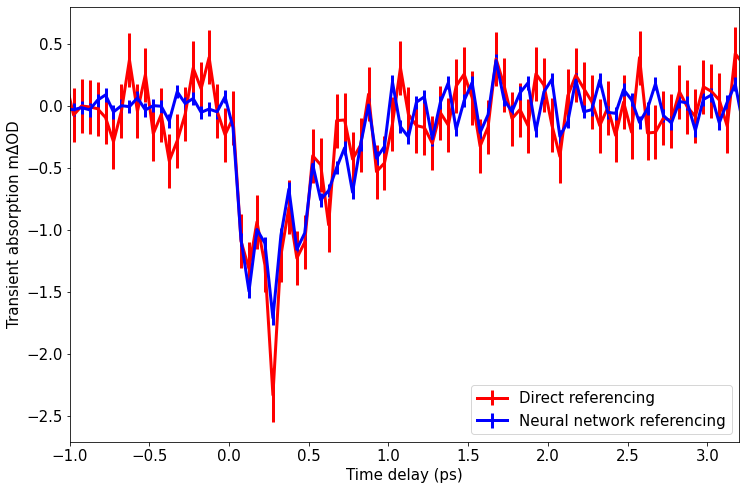

In [35]:
plt.figure(figsize=(12,8))
plt.rc('font', size=15) 
[timing_sort, Intensity_sort_binned,Error_sort_binned]=Single_Hermonic_Sort(Intensity_list,Error_list,timing,6,binnings[6])
#fig.add_trace(go.Scatter(x=,y=Intensity_sort_binned,name='HH '+str(order),error_y=dict(type='data',array=Error_sort_binned,visible=True)))
xshift=0.425
Intensity_sort_binned2=-np.log10(Intensity_sort_binned*2+1)
sortedData2=-np.log10(sortedData)


# 
mean1=np.mean(Intensity_sort_binned2[71:91])
mean2=np.mean(sortedData2[0:20])
Error1=np.std(Intensity_sort_binned2[71:91])
Error2=np.std(sortedData2[0:20])
print(Error1)
print(Error2)
print('Error improved by x ' + str(Error2/Error1))
plt.errorbar(sortedtiming-xshift,(sortedData2-mean2)*1000,(Sigma_rawData*0+Error2)*1000,linewidth=3,color='r')
plt.errorbar(timing_sort-xshift,(Intensity_sort_binned2-mean1)*1000,(Error_sort_binned*0+Error1)*1000,linewidth=3,color='b')

plt.xlim((-1,3.2))
#plt.text(0.7,-0.001,f'{1/popt2[2]*1000:.0f}' + ' fs', fontsize=15)
#plt.text(0.6,-0.005,f'{1/popt[2]*1000:.0f}' + ' fs', fontsize=15)
plt.xlabel('Time delay (ps)')
plt.ylabel('Transient absorption m' + u"\u0394"+"OD")
plt.legend(['Direct referencing','Neural network referencing'])
plt.savefig("ComparisonNN-HH26.svg")

In [10]:
fig2 = go.Figure()
fig = go.Figure()
fig3 = go.Figure()


def func(x,a1,b1,c1,d1,e1,f1,g1,h1,i1,a3,f,j1,h2,a4,i2):
    step=scipy.special.erf(b1*(x-a1))+1

    return step*(-c1*np.sin(2*np.pi*f*x+d1)*np.exp(-x*e1+f1)+g1-h1*np.exp(-(x-a3)*i1)-h2*np.exp(-(x-a4)*i2)) +j1

def func2(x,t0,tr,td1,A1,b0,b1):
    step=scipy.special.erf(tr*(x-t0))+1

    return step*(b1-A1*np.exp(-td1*x)) +b0


harmonics2=np.int16(np.linspace(0,8,9))
binnings=np.array([4,4,4,4,4,2,4,4,4,4,4,4])
for jj in harmonics2:
    [timing_sort, Intensity_sort_binned,Error_sort_binned]=Single_Hermonic_Sort(Intensity_list,Error_list,timing,jj,binnings[jj])
    order=31-jj
    
    fig2.add_trace(go.Scatter(x=timing_sort,y=Intensity_sort_binned,name='data HH 31'))
    xFit=timing_sort
    yFit=Intensity_sort_binned
    #boundU=[0.4,18,0.0009,3,10,1,0.00001,0.004,4,0.4,7,1,1,1,10]
    #boundL=[-0.5,8,0.0004,0,0,0,0,-0.00001,0.5,-0.1,2,-1,-1,-1,-2]
    boundU=[0.4,18,30,0.007,0.007,0.007]
    boundL=[-0.5,8,0,-0.007,-0.007,-0.007]

    #plt.plot(timing_sort[10:63],Intensity_sort[10:63])
    popt, pcov = curve_fit(func2, xFit, yFit,bounds=(boundL, boundU))
    #popt[2]=popt[2]*1.5

    fig2.add_trace(go.Scatter(x=timing_sort,y=func2(timing_sort, *popt),name='Fit'))
    fig.add_trace(go.Scatter(x=timing_sort,y=Intensity_sort_binned-func2(timing_sort, *popt),name='HH '+str(order),error_y=dict(type='data',array=Error_sort_binned,visible=True)))


    spectrum=fft(np.append(Intensity_sort_binned-func2(timing_sort, *popt),np.zeros(50)))
    N=np.size(np.append(Intensity_sort_binned-func2(timing_sort, *popt),np.zeros(50)))
    T=0.025
    frq=fftfreq(N,T)[:N//2]
    fig3.add_trace(go.Scatter(x=frq,y=2.0/N * np.abs(spectrum[0:N//2]),name='HH '+str(order),))




fig.update_layout(width=1300, height=700,title='transient absorption TiSe\u2082',xaxis_title='Delay [ps]', yaxis_title=u"\u0394"+"T/T")
fig.show()
fig2.update_layout(width=1300, height=700,title='transient absorption TiSe\u2082',xaxis_title='Delay [ps]', yaxis_title=u"\u0394"+"T/T")
fig2.show()

fig3.update_layout(width=1300, height=700,title='Fourier Amplitude',xaxis_title='Frequency [THz]', yaxis_title="Fourier Amplitude")
fig3.show()
